In [2]:
!git clone --depth 1 https://github.com/Hzzone/PseCo
import sys
sys.path.insert(0, './PseCo')
!nvidia-smi
# make sure that GPU is used

fatal: destination path 'PseCo' already exists and is not an empty directory.
Thu Jan 15 15:22:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                   

In [ ]:
!pip install -r requirements.txt
# import gdown
# gdown.download_folder('https://drive.google.com/drive/folders/1RwxDPiL3dcUJc14arrvJkgTpI2XSddGF')

In [ ]:
import os
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_tensor
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import tqdm
import albumentations as A
import torch.nn as nn
import torchvision
import torchvision.ops as vision_ops
from ops.foundation_models.segment_anything.utils.amg import batched_mask_to_box
from ops.ops import _nms, plot_results, convert_to_cuda
plt.rcParams["figure.dpi"] = 300
torch.cuda.set_device(0)
torch.autograd.set_grad_enabled(False)
!gpustat

121.pami.group            Tue Dec 12 22:22:59 2023  515.105.01
[0] NVIDIA A100-PCIE-40GB | 27°C,   0 % | 19045 / 40960 MB | zzhuang(5957M) zzhuang(3121M) zzhuang(7853M)
[1] NVIDIA A100-PCIE-40GB | 27°C,   0 % | 31043 / 40960 MB | yfyuan(10277M) yfyuan(10927M) zzhuang(9271M)
[2] NVIDIA A100-PCIE-40GB | 65°C,  91 % | 15099 / 40960 MB | zhengxin(14533M)
[3] NVIDIA A100-PCIE-40GB | 28°C,   0 % |   568 / 40960 MB |


In [ ]:
project_root = './PseCo'

In [ ]:
def read_image(fname):
    img = Image.open(f'{project_root}/data/fsc147/images_384_VarV2/{fname}')
    transform = A.Compose([
        A.LongestMaxSize(1024),
        A.PadIfNeeded(1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    img = Image.fromarray(transform(image=np.array(img))['image'])
    return img

In [ ]:
from ops.foundation_models.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, build_sam, build_sam_vit_b, build_sam_vit_h

# sam = build_sam_vit_b().cuda().eval()
sam = build_sam_vit_h().cuda().eval()

In [ ]:
clip_text_prompts = torch.load(f'{project_root}/data/fsc147/clip_text_prompt.pth', map_location='cpu')

In [ ]:
all_data = torch.load(f'{project_root}/data/fsc147/sam/all_data_vith.pth', map_location='cpu')
all_predictions = torch.load(f'{project_root}/data/fsc147/sam/all_predictions_vith.pth', map_location='cpu')

all_pseudo_boxes = torch.load(f'{project_root}/data/fsc147/sam/pseudo_boxes_data_vith.pth', map_location='cpu')

In [ ]:
for fname in tqdm.tqdm(all_data):
    target = all_data[fname]
    target['image_id'] = fname
    target['predictions'] = all_predictions[fname]
    if all_data[fname]['split'] == 'train':
        target['annotations']['boxes'] = all_pseudo_boxes[fname]['pred_boxes']
        target['annotations']['ious'] = all_pseudo_boxes[fname]['pred_ious']
all_image_list = {'train': [], 'val': [], 'test': [], 'all': []}
for fname in all_data:
    all_image_list[all_data[fname]['split']].append(fname)
    all_image_list['all'].append(fname)

100%|███████████████████████████████████| 6054/6054 [00:00<00:00, 599200.43it/s]


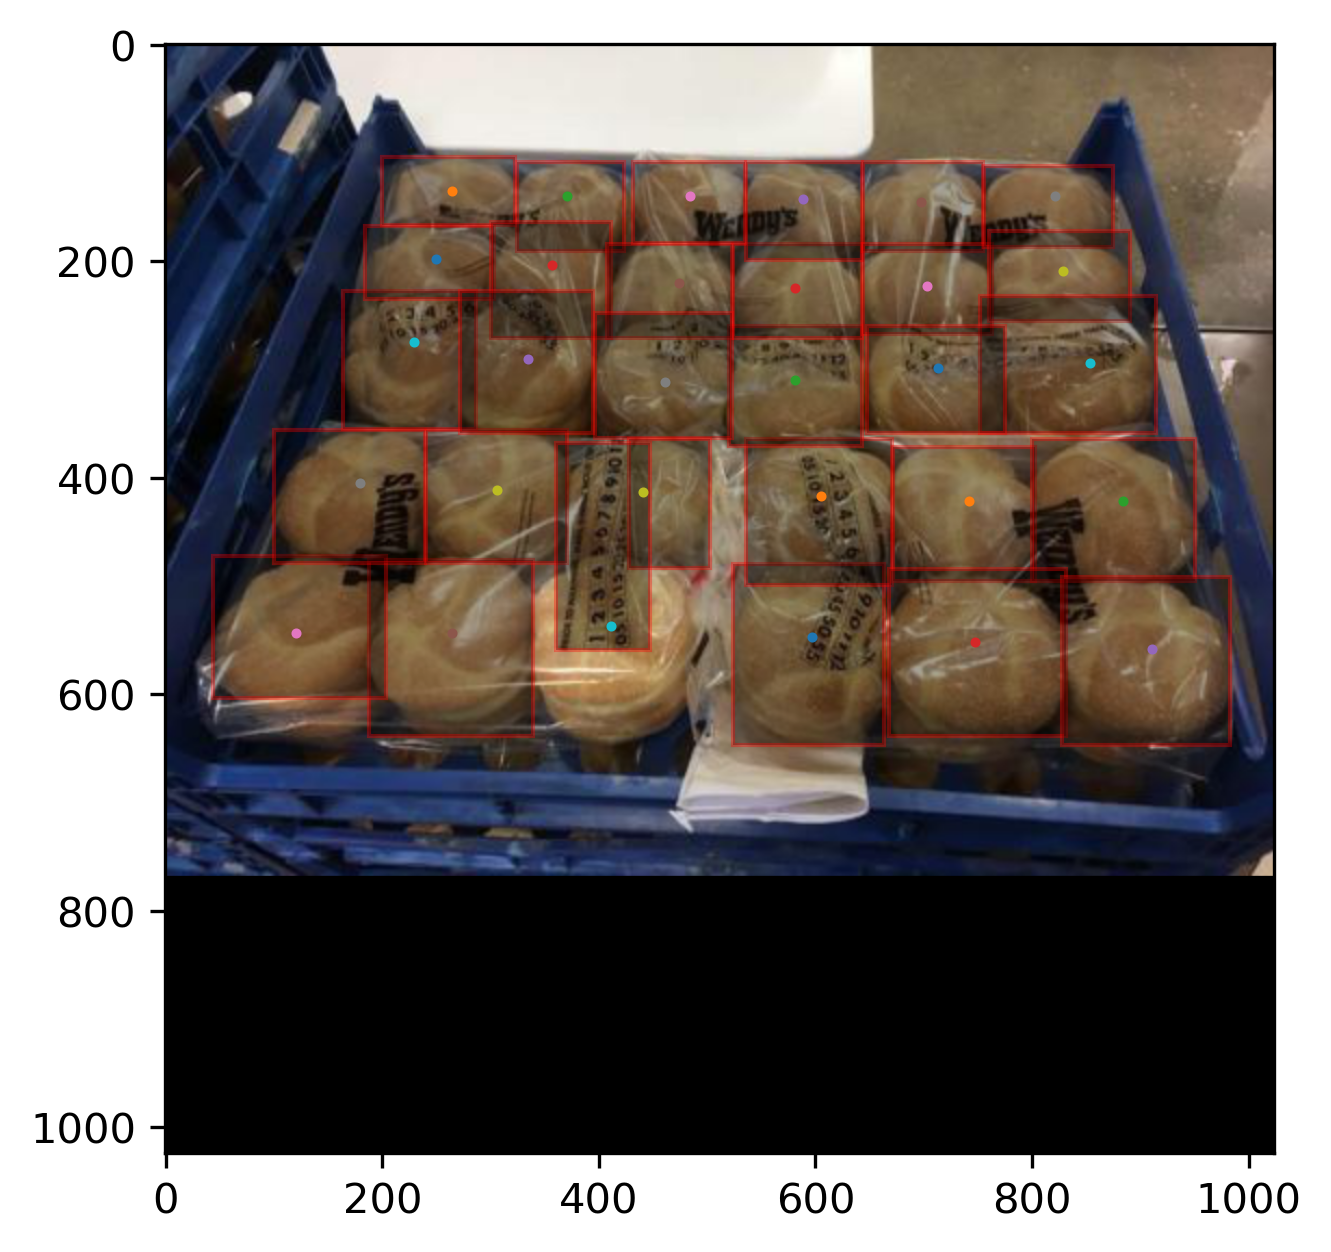

In [ ]:
fname = '22.jpg'
plot_results(read_image(fname),
bboxes=all_data[fname]['annotations']['boxes'],
points=all_data[fname]['annotations']['points'],
             )

In [ ]:
from models import ROIHeadMLP as ROIHead
cls_head = ROIHead().cuda().eval()
# zeroshot
# cls_head.load_state_dict(torch.load(f'{project_root}/data/fsc147/checkpoints/MLP_small_box_w1_zeroshot.tar', map_location='cpu')['cls_head'])
# fewshot
cls_head.load_state_dict(torch.load(f'{project_root}/data/fsc147/checkpoints/MLP_small_box_w1_fewshot.tar', map_location='cpu')['cls_head'])

<All keys matched successfully>

'train'

'bread rolls'

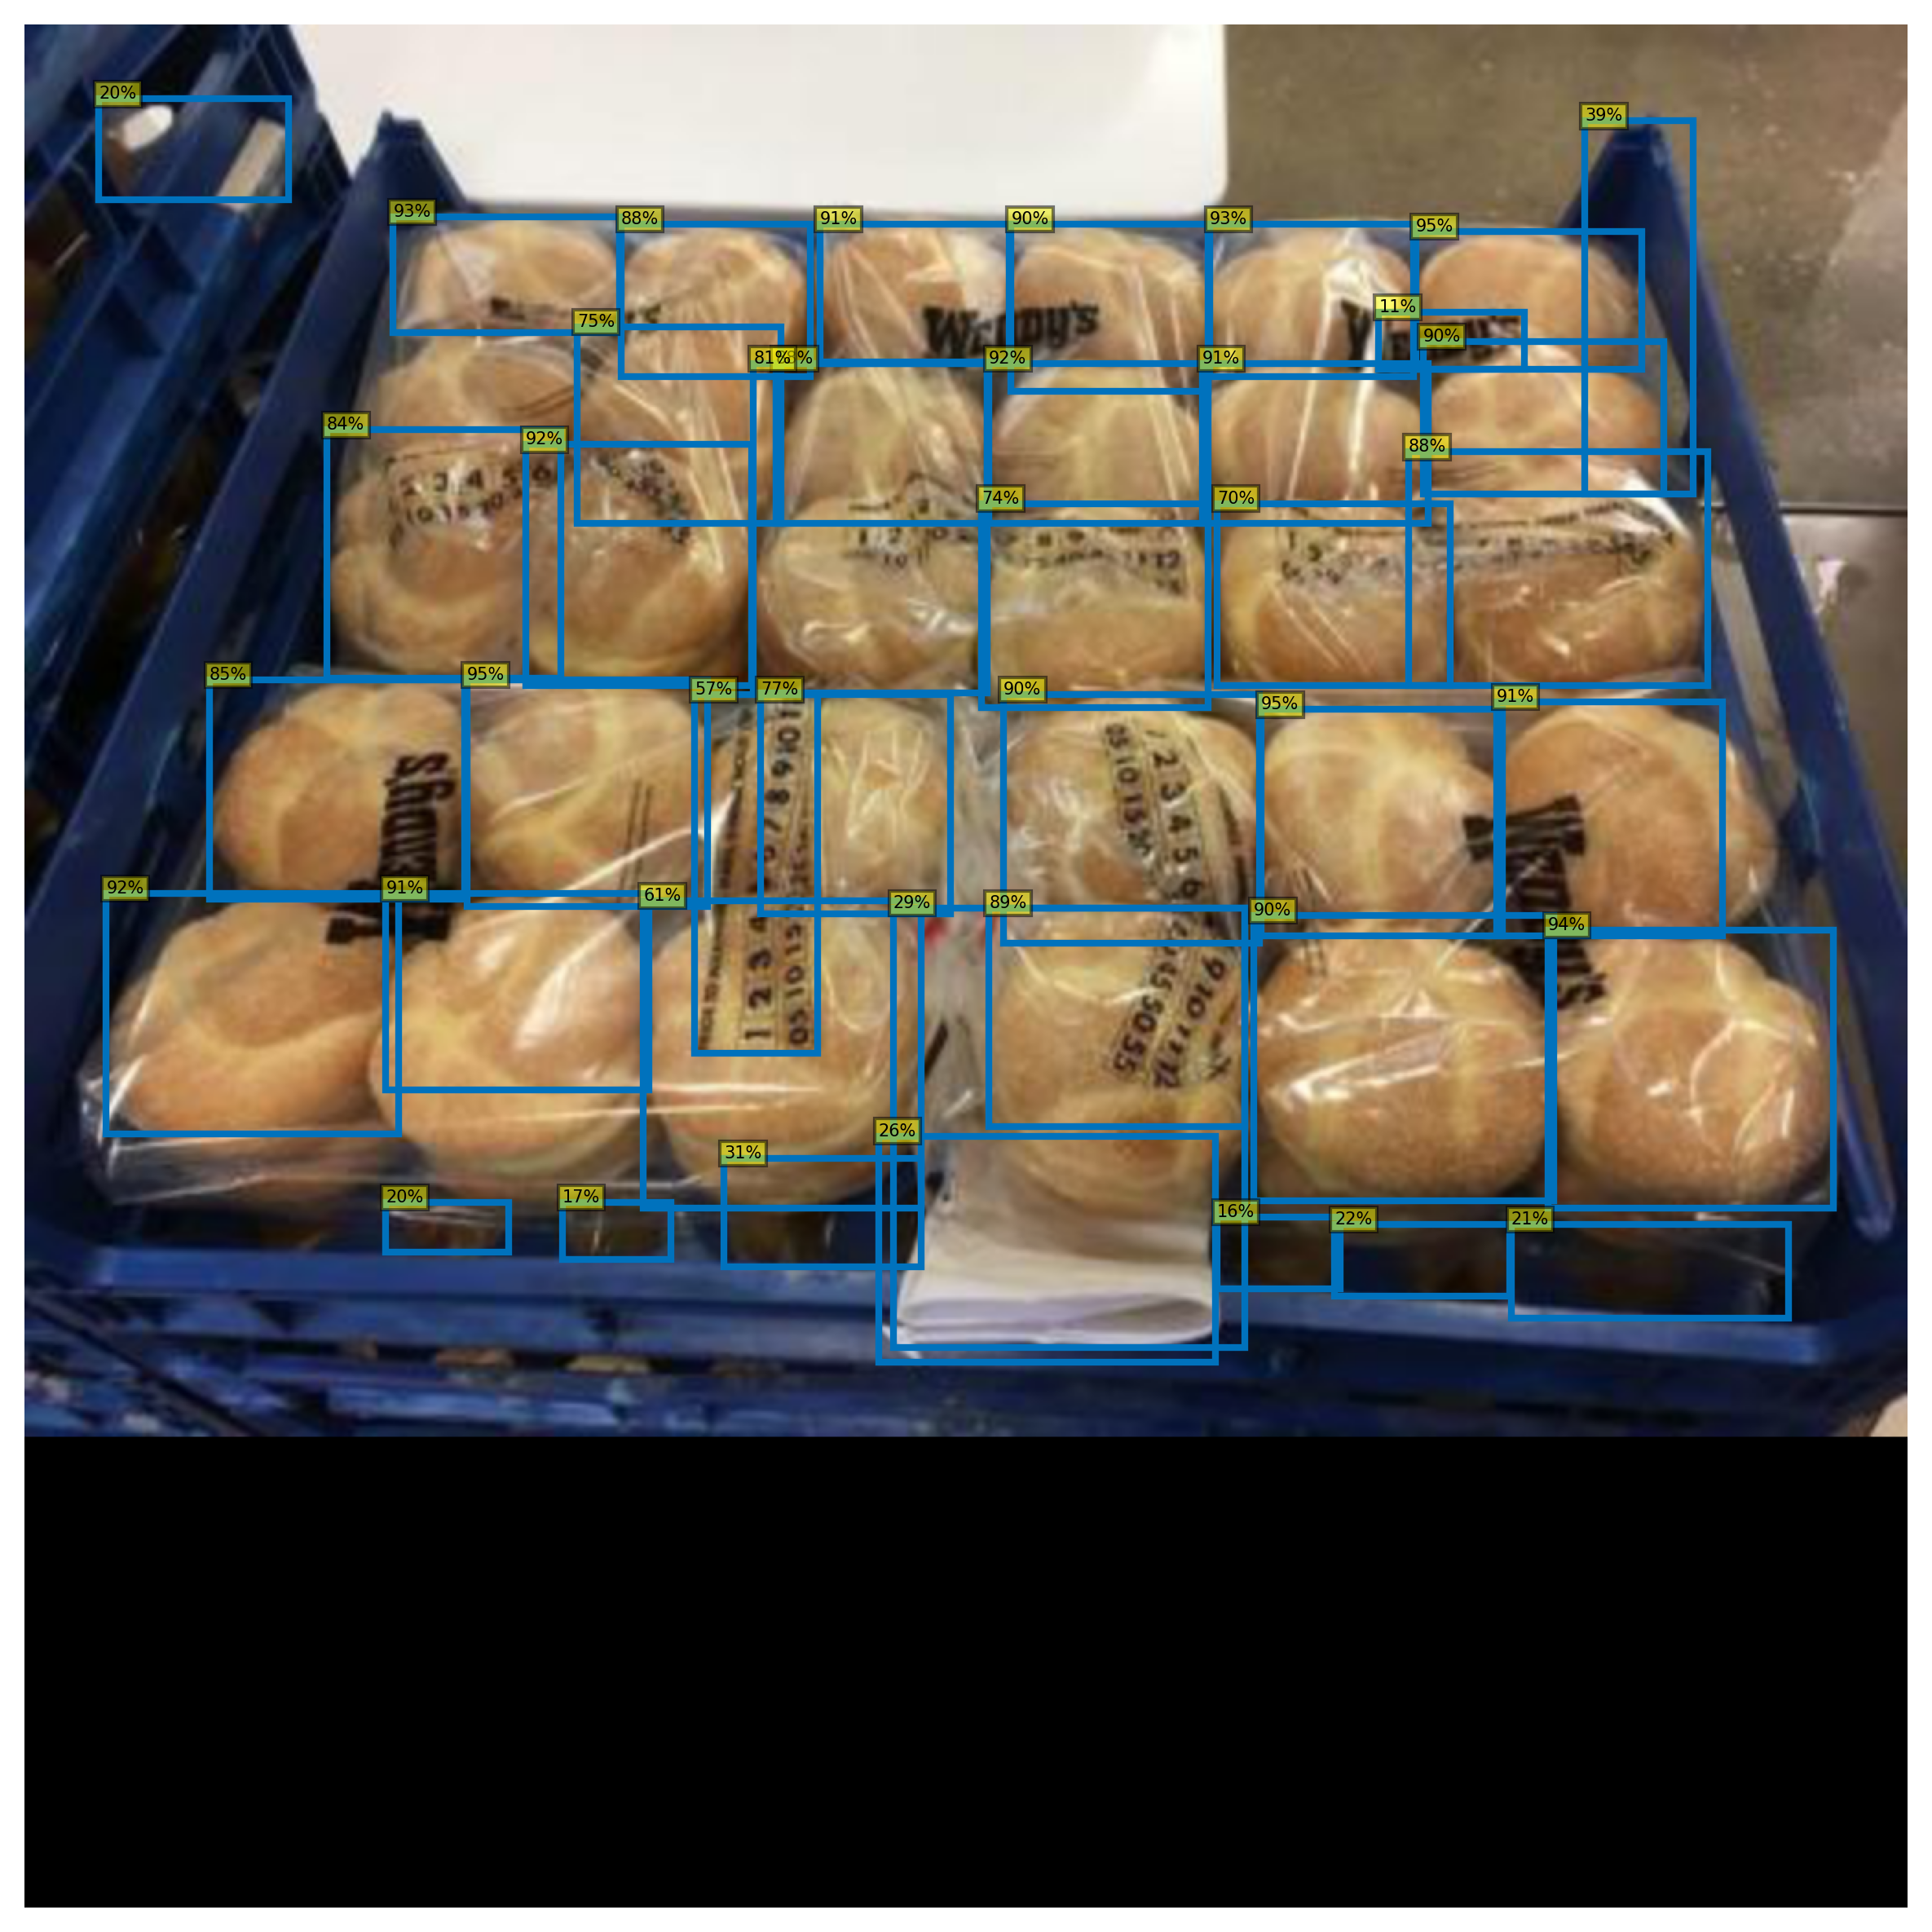

In [ ]:
display(all_data[fname]['split'])
display(all_data[fname]['class_name'])
_ = cls_head.eval()
annotations = all_data[fname]['annotations']
gt_points = annotations['points']
with torch.no_grad():
    # zero-shot
    # example_features = clip_text_prompts[all_data[fname]['class_name']].unsqueeze(0).cuda()
    # few-shot
    example_features = all_data[fname]['example_clip_features'].cuda()
    min_scores = 0.05
    max_points = 1000
    pred_points_score = all_data[fname]['predictions']['pred_points_score']
    mask = torch.zeros(pred_points_score.size(0))
    mask[:min(pred_points_score.size(0), max_points)] = 1
    mask[pred_points_score < min_scores] = 0
    pred_boxes = all_data[fname]['predictions']['pred_boxes'][mask.bool()].cuda()
    pred_ious = all_data[fname]['predictions']['pred_ious'][mask.bool()].cuda()
    cls_outs = []
    for indices in torch.arange(len(pred_boxes)).split(128):
        cls_outs_ = cls_head(all_data[fname]['features'].cuda(), [pred_boxes[indices], ], [example_features, ] * len(indices))
        pred_logits = cls_outs_.sigmoid().view(-1, len(example_features), 5).mean(1)
        pred_logits = pred_logits * pred_ious[indices]
        cls_outs.append(pred_logits)
    cls_outs = torch.cat(cls_outs)
    pred_boxes = pred_boxes[torch.arange(len(pred_boxes)), torch.argmax(cls_outs, dim=1)]
    scores = cls_outs.max(1).values
    indices = vision_ops.nms(pred_boxes, scores, 0.5)
    pred_boxes = pred_boxes[indices]
    scores = scores[indices]
    pred_points = all_data[fname]['predictions']['pred_points'][mask.bool()].cuda()[indices]
plt.figure(figsize=(10,10))
COLORS = [[0.000, 0.447, 0.741], ]
h, w = all_data[fname]['height'], all_data[fname]['width']
scale = 1024 / max(h, w)
plt.imshow(read_image(fname))
for p, (xmin, ymin, xmax, ymax), c in zip(scores, pred_boxes.tolist(), COLORS * len(pred_boxes)):
    if p < 0.1:
        continue
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color=c,
                               linewidth=2.0,
                               ))
    text = f'{int(p*100)}%'
    plt.gca().text(xmin, ymin, text,
            fontsize=5,
            bbox=dict(facecolor='yellow',
                      boxstyle='square,pad=.25',
                      alpha=0.5)
            )
plt.axis('off')
plt.show()